In [3]:
from data_class import DataClass
from linear_noise_scheduler import LinearNoiseScheduler
from blocks import Unet

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
IMG_SIZE = 64
BATCH_SIZE = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_class = DataClass(IMG_SIZE)
data = data_class.load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


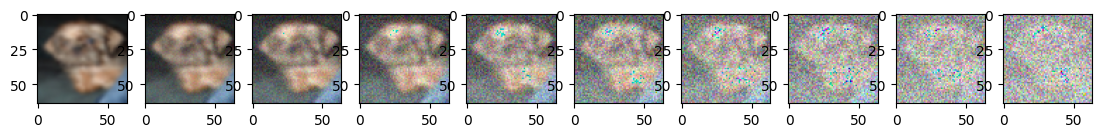

In [6]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15, 15))
num_images = 10
T = 300 # timesteps
stepsize = int(T/num_images)
scheduler = LinearNoiseScheduler(T)

for i in range(0, T, stepsize):
    t = torch.Tensor([i]).type(torch.int64)
    plt.subplot(1, num_images+1, int(i/stepsize) + 1)
    img, noise = scheduler.add_noise(image, t)
    data_class.show_tensor_image(img)

In [20]:
model = Unet()
print(f"{sum(p.numel() for p in model.parameters())/10**6}M paramters")

62.438883M paramters


In [21]:
def get_loss(model, x_0, t):
    x_noisy, noise = scheduler.add_noise(x_0, t, device=device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [22]:
@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15, 15))
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = scheduler.sample_timestep(img, t, model(img, t))
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            data_class.show_tensor_image(img.detach().cpu())
    plt.show()

Epoch 0 | step 000 Loss: 0.4941790997982025 


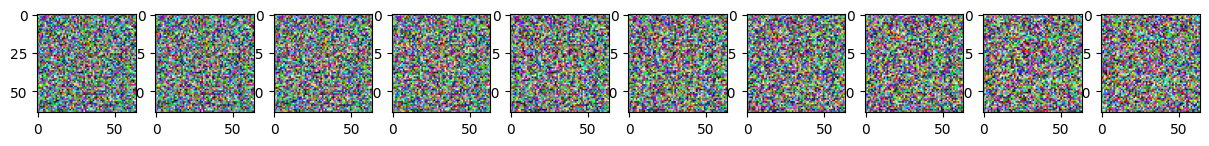

Epoch 0 | step 100 Loss: 0.08487477898597717 


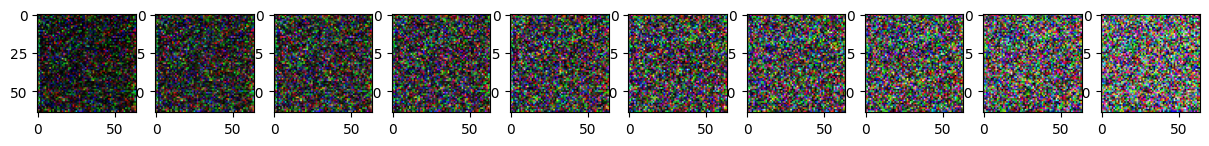

Epoch 0 | step 200 Loss: 0.12227964401245117 


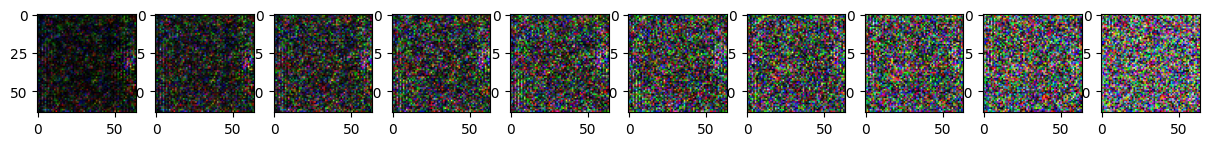

Epoch 0 | step 300 Loss: 0.061376508325338364 


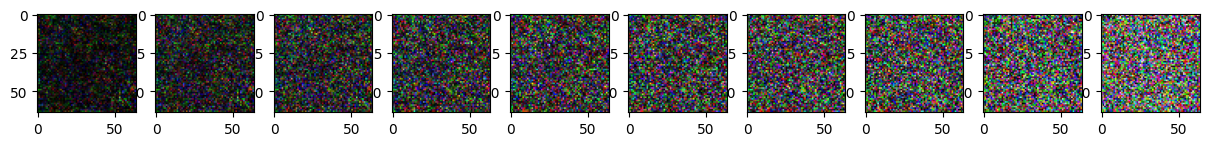

Epoch 0 | step 400 Loss: 0.05417925864458084 


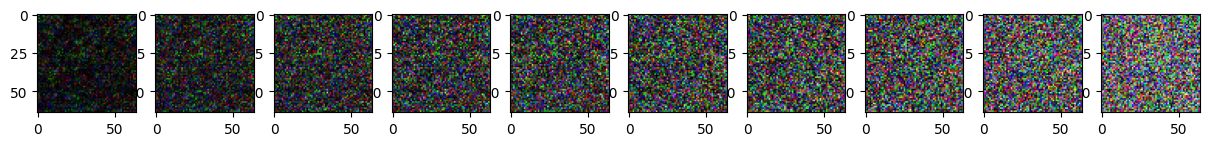

Epoch 1 | step 000 Loss: 0.05543733388185501 


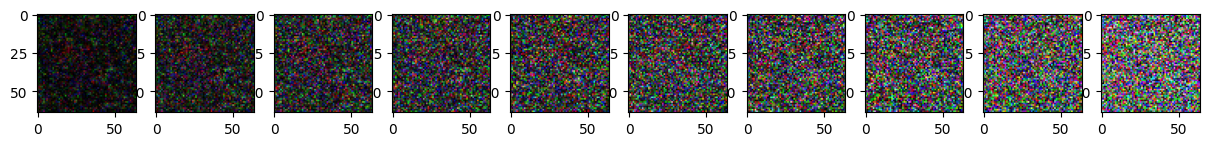

Epoch 1 | step 100 Loss: 0.05697772651910782 


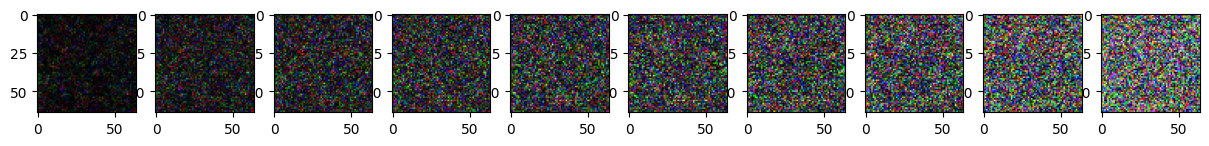

Epoch 1 | step 200 Loss: 0.04888386279344559 


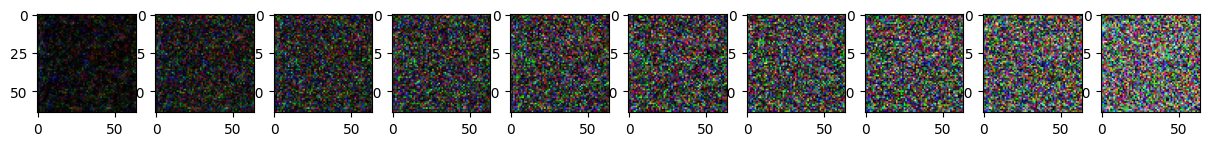

Epoch 1 | step 300 Loss: 0.04432877153158188 


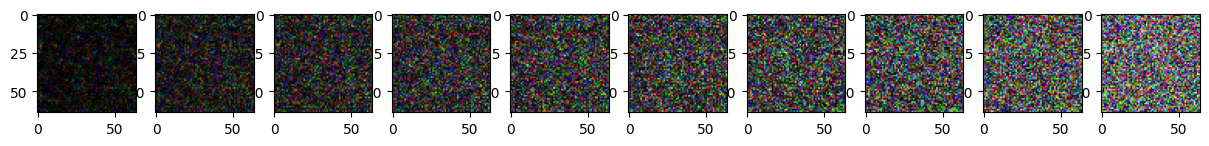

Epoch 1 | step 400 Loss: 0.0491933636367321 


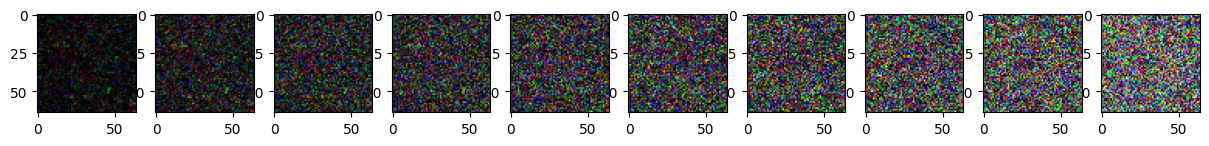

Epoch 2 | step 000 Loss: 0.044798702001571655 


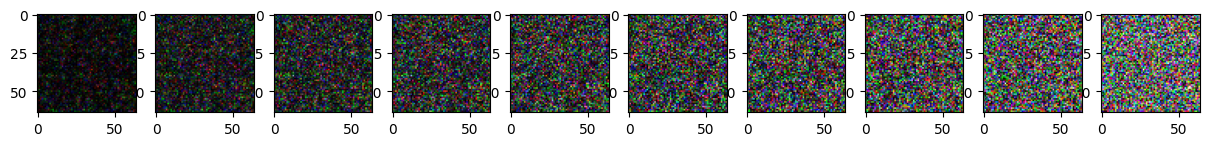

Epoch 2 | step 100 Loss: 0.04530419036746025 


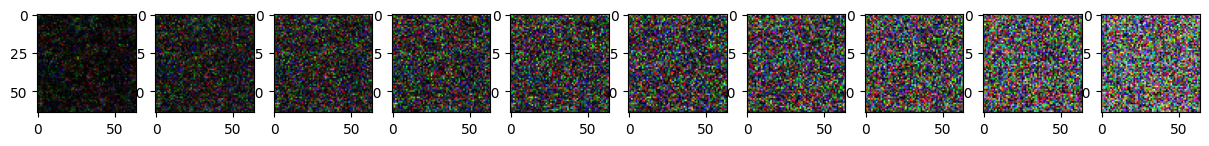

Epoch 2 | step 200 Loss: 0.043360691517591476 


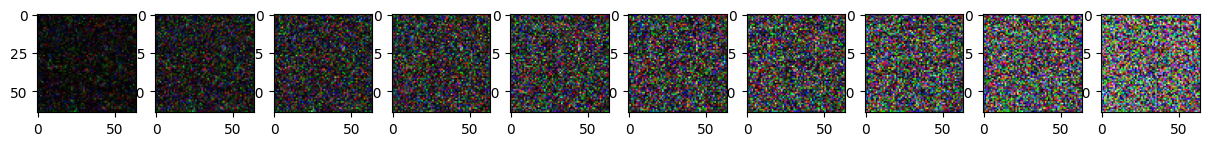

Epoch 2 | step 300 Loss: 0.04313218593597412 


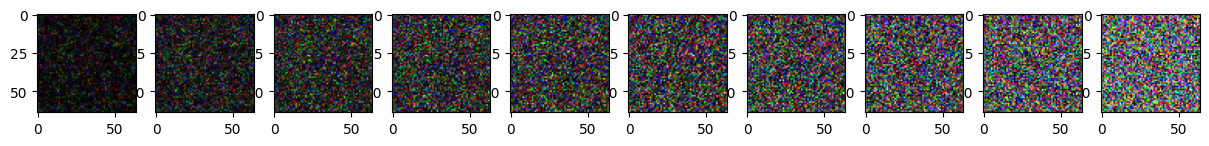

Epoch 2 | step 400 Loss: 0.046649955213069916 


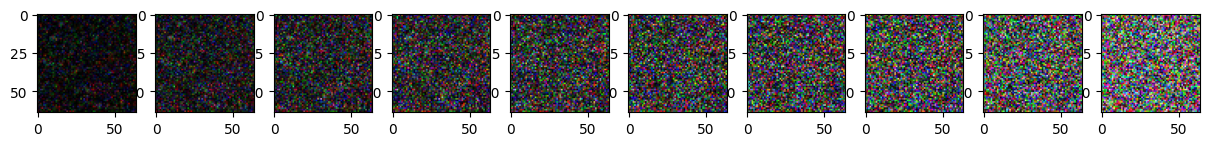

Epoch 3 | step 000 Loss: 0.045110635459423065 


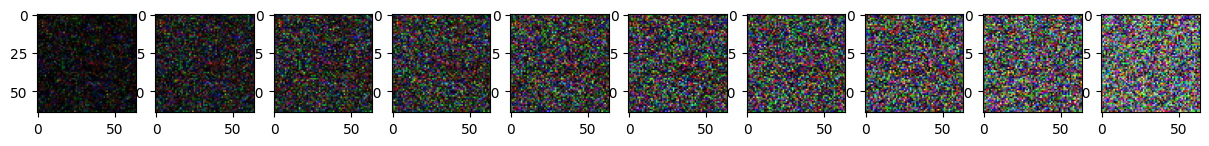

Epoch 3 | step 100 Loss: 0.04294929653406143 


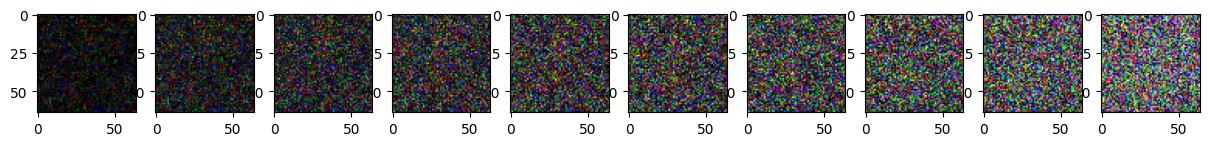

Epoch 3 | step 200 Loss: 0.043642159551382065 


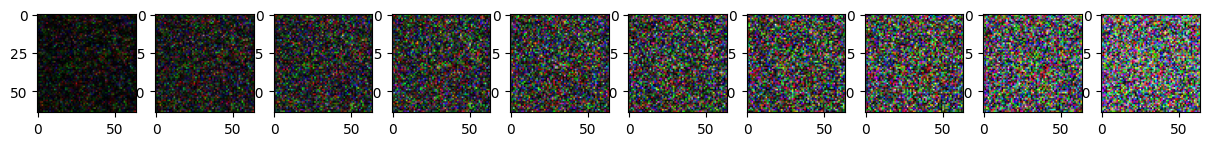

Epoch 3 | step 300 Loss: 0.04268002510070801 


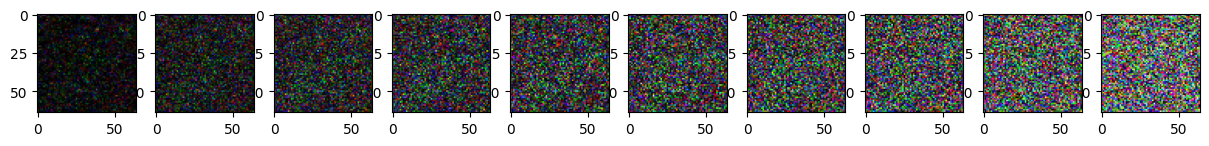

Epoch 3 | step 400 Loss: 0.043992795050144196 


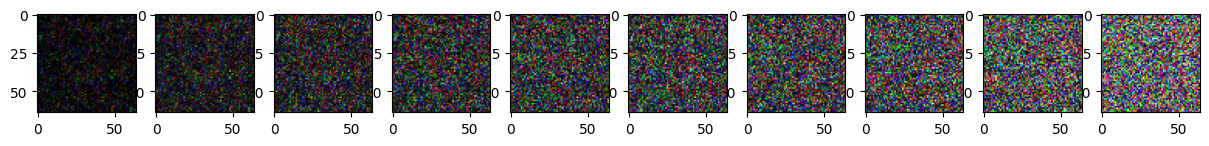

KeyboardInterrupt: 

In [23]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if step % 100 == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()